## Cocktail party problem
### original file by Kevin Hughes


**Problem setup:** A number of people are talking simultaneously and we want to separate each persons speech so we can listen to it separately. Now the caveat with this type of approach is that we need as many mixtures as we have source signals or in terms of the cocktail party problem we need as many microphones as people talking in the room.

First, some technical stuff for loading audio



In [3]:
#Tech stuff
from scipy.io import wavfile
from scipy.signal import resample
import numpy as np
%matplotlib inline
import sys
def load_wav(filename,samplerate=44100):
    
    # load file
    rate, data = wavfile.read(filename)

    # convert stereo to mono
    if len(data.shape) > 1:
        data = data[:,0]/2 + data[:,1]/2

    # re-interpolate samplerate    
    ratio = float(samplerate) / float(rate)
    data = resample(data, len(data) * ratio)
    
    return samplerate, data.astype(np.int16)


In [4]:
#Reading the wavefile
import StringIO
import base64
import struct  

from IPython.core.display import HTML
from IPython.core.display import display
def wavPlayer(data, rate):
    """ will display html 5 player for compatible browser
    The browser need to know how to play wav through html5.
    there is no autoplay to prevent file playing when the browser opens
    Adapted from SciPy.io. and
    github.com/Carreau/posts/blob/master/07-the-sound-of-hydrogen.ipynb
    """
    
    buffer = StringIO.StringIO()
    buffer.write(b'RIFF')
    buffer.write(b'\x00\x00\x00\x00')
    buffer.write(b'WAVE')

    buffer.write(b'fmt ')
    if data.ndim == 1:
        noc = 1
    else:
        noc = data.shape[1]
    bits = data.dtype.itemsize * 8
    sbytes = rate*(bits // 8)*noc
    ba = noc * (bits // 8)
    buffer.write(struct.pack('<ihHIIHH', 16, 1, noc, rate, sbytes, ba, bits))

    # data chunk
    buffer.write(b'data')
    buffer.write(struct.pack('<i', data.nbytes))

    if data.dtype.byteorder == '>' or (data.dtype.byteorder == '=' and sys.byteorder == 'big'):
        data = data.byteswap()

    buffer.write(data.tostring())
    # return buffer.getvalue()
    # Determine file size and place it in correct
    # position at start of the file.
    size = buffer.tell()
    buffer.seek(4)
    buffer.write(struct.pack('<i', size-8))
    
    val = buffer.getvalue()
    
    src = """
    <head>
    <meta http-equiv="Content-Type" content="text/html; charset=utf-8">
    <title>Simple Test</title>
    </head>
    
    <body>
    <audio controls="controls" style="width:600px" >
      <source controls src="data:audio/wav;base64,{base64}" type="audio/wav" />
      Your browser does not support the audio element.
    </audio>
    </body>
    """.format(base64=base64.encodestring(val))
    display(HTML(src))

Now we can test the audio reading stuff. Following the original .ipynb file, I will use Starcraft sounds (that is from my childhood, yea as well, how many of you remembers what it is?), but you can use your own wave files for fun. The files are downloaded from http://wavs.unclebubby.com/computer/starcraft/

/home/ivan/miniconda2/lib/python2.7/site-packages/scipy/signal/signaltools.py:1889: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Y = zeros(newshape, 'D')


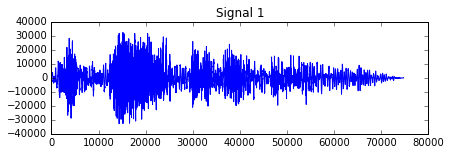

In [5]:
#The first sound
import pylab as pl
import numpy as np
# load
fs1,s1 = load_wav('tbawht02.wav') # Terran Battlecruiser - "Good day, commander."

# plot
pl.figure(figsize=(6.75,2))
pl.plot(s1)
pl.title('Signal 1')
pl.show()

# player
wavPlayer(s1, fs1)

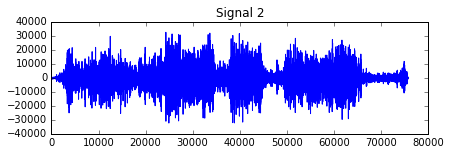

In [6]:
# load
fs2,s2 = load_wav('TMaRdy00.wav') # Terran Marine - "You want a piece of me, boy?"

# plot
pl.figure(figsize=(6.75,2))
pl.plot(s2)
pl.title('Signal 2')
pl.show()

# player
wavPlayer(s2, fs2)


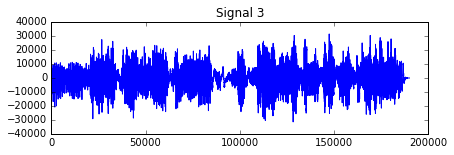

In [7]:
# load
fs3,s3 = load_wav('PDrPss02.wav') # Protoss Zealot - "Drop your weapon. You have 15 seconds to comply"

# plot
pl.figure(figsize=(6.75,2))
pl.plot(s3)
pl.title('Signal 3')
pl.show()

# player
wavPlayer(s3, fs3)


The signals are mixed by creating a mixing matrix A and taking the dot product of A with the signals S.

Afterwards I plot the mixed signals and create the wavPlayers, so you can listen!
The code below uses scikit-learn package, which can be installed (if it is not installed)

```
   conda install scikit-learn
```
(Anaconda Python distribution assumed)



Mixing Matrix:
[[ 1.   0.5  0.5]
 [ 0.5  1.   0.5]
 [ 0.5  0.5  1. ]]


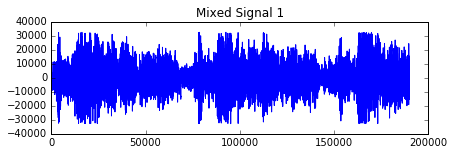

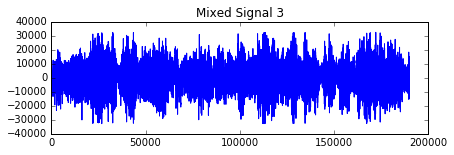

In [11]:
import numpy as np

# Adjust for different clip lengths
fs = fs1
length = max([len(s1), len(s2), len(s3)])
s1 = np.resize(s1, (length,1))
s2 = np.resize(s2, (length,1))
s3 = np.resize(s3, (length,1))

S = (np.c_[s1, s2, s3]).T

# Mixing Matrix
#A = np.random.uniform(size=(3,3))
#A = A / A.sum(axis=0)
A = np.array([[1, 0.5, 0.5],
              [0.5, 1, 0.5], 
              [0.5, 0.5, 1]]) 
print 'Mixing Matrix:'
print A.round(2)

# Mix Signals
X = np.dot(A,S)
#Some noise as well
X = X * (1 + 0 * np.random.randn(X.shape[0], X.shape[1]))
# Mixed Signal i
for i in range(X.shape[0]):
    pl.figure(figsize=(6.75,2))
    pl.plot((X[i]).astype(np.int16))
    pl.title('Mixed Signal %d' % (i+1))
    pl.show()
    wavPlayer((X[i]).astype(np.int16), fs)

Now we have to separate the mixtures. For this we use the ``FastICA`` method from the ``sklearn`` module. Presumably, we will discuss it later on, when we will talk about matrix decompositions. The idea is to find a matrix $W$ that unmixes the mixture
$$X=WY,$$
such that $X$ are as independent, as possible. There are different criteria of independence. Independent of two random variables requires infinite number of equations to be solved, and there are many variants for doing this, and this is still an active research topic.



In [12]:
from sklearn.decomposition import FastICA
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X.T).T  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix


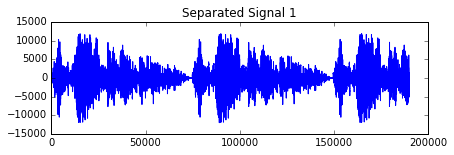

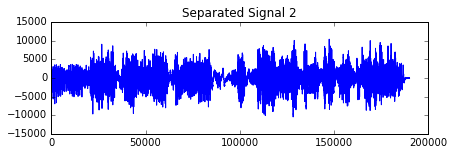

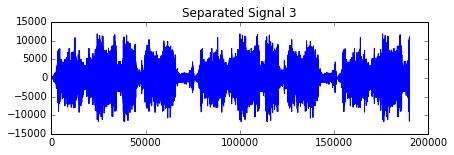

In [13]:
# Show separation results

# Separated Signal i
gain = 1000000
for i in range(S_.shape[0]):
    pl.figure(figsize=(6.75,2))
    pl.plot((gain*S_[i]).astype(np.int16))
    pl.title('Separated Signal %d' % (i+1))
    pl.show()
    wavPlayer((gain*S_[i]).astype(np.int16), fs)
